In [16]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt 
from carvekit.api.high import HiInterface

In [17]:
#######
# Setup
#######

PORT = 8813
rr.init("SHOUT")
rr.connect(addr=f'127.0.0.1:{PORT}')

## get data
ACQUISITION_END = 44 * 5
subsampling_frame = 5
path = os.path.join(b3d.get_assets_path(), "shared_data_bucket/input_data/demo_reel_place_and_pickup.r3d.video_input_part1.npz")
video_input = b3d.VideoInput.load(path) 

image_width, image_height, fx,fy, cx,cy,near,far = np.array(video_input.camera_intrinsics_depth)
image_width, image_height = int(image_width), int(image_height)
fx,fy,cx,cy,near,far = float(fx),float(fy), float(cx),float(cy),float(near),float(far)

rgbs_all = video_input.rgb / 255.0
xyzs = video_input.xyz[:ACQUISITION_END:subsampling_frame, ...]
rgbs = rgbs_all[:ACQUISITION_END:subsampling_frame, ...]

# Resize rgbs to be same size as depth.
rgbs_resized = jnp.clip(jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    rgbs, (xyzs.shape[1], xyzs.shape[2], 3), "linear"
), 0.0, 1.0)

# for img in rgbs_resized:
#     rr.log("/gt_img", rr.Image(jnp.clip(img, 0.0, 1.0)))
# # Get GT camera poses.
gt_camera_poses = jax.vmap(lambda x,y: Pose(x,y), in_axes=(0,0))(
    video_input.camera_positions,
    video_input.camera_quaternions
)[::subsampling_frame, ...]

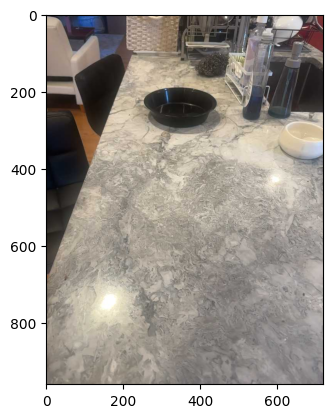

In [19]:
plt.imshow(video_input.rgb[ACQUISITION_END]/255)

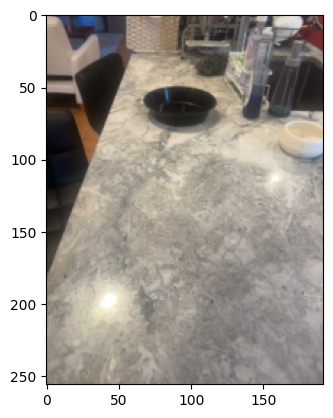

In [20]:
plt.imshow(rgbs_resized[-1])

In [21]:
## setup segmentation net
interface = HiInterface(object_type="hairs-like",  # Can be "object" or "hairs-like".
                        batch_size_seg=5,
                        batch_size_matting=1,
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        seg_mask_size=640,  # Use 640 for Tracer B7 and 320 for U2Net
                        matting_mask_size=2048,
                        trimap_prob_threshold=231,
                        trimap_dilation=30,
                        trimap_erosion_iters=5,
                        fp16=False)

del rgbs_all

In [22]:
#######
# Build a mesh of the background scene. (not masking anything out)
#######

TIME_FOR_MESH = 0
# output_images = interface([hgps.viz.get_rgb_pil_image(rgbs_resized[TIME_FOR_MESH])])
# mask  = jnp.array([jnp.array(output_image)[..., -1] > 0.5 for output_image in output_images])[0]

point_cloud_for_mesh = xyzs[TIME_FOR_MESH].reshape(-1, 3)
colors_for_mesh = rgbs_resized[TIME_FOR_MESH].reshape(-1, 3)

_vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud_for_mesh, colors_for_mesh, 0.003 * 2 * jnp.ones(len(colors_for_mesh))
)

object_pose = Pose.from_translation(_vertices.mean(0))  # CAMERA frame object pose
vertices = object_pose.inverse().apply(_vertices)  # WORLD frame vertices


In [23]:
# subset the mesh
subset1 = ((point_cloud_for_mesh < point_cloud_for_mesh.mean(0) * 1.5)).all(1)
subset2 = ((point_cloud_for_mesh > point_cloud_for_mesh.mean(0) * 0.75)).all(1)
subset = subset1 | subset2 

point_cloud_subset = point_cloud_for_mesh[subset]
colors_for_mesh_subset = colors_for_mesh[subset]


_vertices_subset, faces_subset, vertex_colors_subset, face_colors_subset = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud_subset, colors_for_mesh_subset, 0.003 * 2 * jnp.ones(len(colors_for_mesh_subset))
)

object_pose_subset = Pose.from_translation(_vertices_subset.mean(0))  # CAMERA frame object pose
vertices_subset = object_pose_subset.inverse().apply(_vertices_subset)  # WORLD frame vertices

vertices_subset_to_whole = object_pose.as_matrix() @ jnp.linalg.inv(object_pose_subset.as_matrix())
vertices_subset_to_whole_xfm = Pose(position=vertices_subset_to_whole[:3,-1], 
                                    quaternion=Pose.identity_quaternion)

In [24]:
# viz initial scene (camera frame)
rr.log("3d/mesh/", rr.Transform3D(translation=object_pose.pos, rotation=rr.Quaternion(xyzw=object_pose.quat)))
rr.log(
    "/3d/mesh",
    rr.Mesh3D(
        vertex_positions=_vertices,
        indices=faces,
        vertex_colors=vertex_colors
    ),
    timeless=True
)    

rr.log("3d/mesh/", rr.Transform3D(translation=object_pose.pos, rotation=rr.Quaternion(xyzw=object_pose.quat)))
rr.log(
    "/3d/mesh/partial",
    rr.Mesh3D(
        vertex_positions=_vertices_subset,
        indices=faces_subset,
        vertex_colors=vertex_colors_subset
    ),
    timeless=True
)    

In [25]:
#######
# setup renderer and model functions
#######

renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)
from b3d.model import model_gl_factory

## model and inference. 
model = model_gl_factory(renderer)
importance_jit = jax.jit(model.importance)
update_jit = jax.jit(model.update)

## trace handlers
# Enumerator( 
        # "update_choices",   # trace, key, args ... trace.update
        # "update_choices_with_weight", # 
        # "update_choices_get_score",  # trace.update(...).get_score()
        # "enumerate_choices", 
        # "enumerate_choices_with_weights",
        # "enumerate_choices_get_scores",
# )

enumerator = b3d.make_enumerator(["camera_pose"])
enumerator_observations = b3d.make_enumerator(["observed_rgb", "observed_depth"])

## update functions.
update_jit = jax.jit(lambda key, trace, choices: model.update(key, trace, choices, genjax.Diff.tree_diff_no_change(trace.get_args()))[0])


In [26]:
## setup enumeration 
translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.01, 0.01, 5),
        jnp.linspace(-0.01, 0.01, 5),
        jnp.linspace(-0.01, 0.01, 5),
    ),
    axis=-1,
).reshape(-1, 3))

rotation_deltas = jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0,None, None, None))(
    jax.random.split(jax.random.PRNGKey(0), 100),
    Pose.identity(),
    0.001, 100.0
)

In [27]:
@jax.jit
def enumerative_proposal_camera_pose(trace, key):
    key = jax.random.split(key)[0]

    test_poses_tr = trace["camera_pose"] @ translation_deltas
    potential_scores = enumerator.enumerate_choices_get_scores(
        trace, jax.random.PRNGKey(0), test_poses_tr
    )
    
    # top k translations 
    k = 5
    top_scores, top_pose_idxs = jax.lax.top_k(potential_scores, k)

    def _eval_trace(curr_best_pose_score, pose_idx):
        _, curr_best_score = curr_best_pose_score

        test_poses_rot = test_poses_tr[pose_idx] @ rotation_deltas
        potential_scores = enumerator.enumerate_choices_get_scores(
            trace, jax.random.PRNGKey(0), test_poses_rot
        )
        top_idx = potential_scores.argmax()
        top_score = jnp.max(potential_scores)
        curr_best_pose_score = jax.lax.cond(
            top_score > curr_best_score,
            lambda : (test_poses_rot[top_idx], top_score),
            lambda : curr_best_pose_score
        )
        
        return curr_best_pose_score, curr_best_score
          
    top_pose_and_score, _ = jax.lax.scan(_eval_trace, 
                                        (test_poses_tr[top_pose_idxs[0]], top_scores[0]),
                                        top_pose_idxs)
    
    trace = enumerator.update_choices(
        trace, jax.random.PRNGKey(0), top_pose_and_score[0]
    )
    return trace, key


In [28]:
# parameters
color_error, depth_error = (10.0, 0.02)
inlier_score, outlier_prob = (4.0, 0.01)
color_multiplier, depth_multiplier = (1000.0, 1000.0)

arguments_subset = (
        vertices_subset, faces_subset, vertex_colors_subset,
        color_error,
        depth_error,

        inlier_score,
        outlier_prob,

        color_multiplier,
        depth_multiplier
    )

In [29]:
######
# Camera pose tracking
######
CAMERATRACK_START_T = 0
CAMERATRACK_END_T = ACQUISITION_END//subsampling_frame

trace, _ = model.importance(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        {
            "camera_pose": Pose.identity(),
            "object_pose": object_pose_subset,
            "observed_rgb": rgbs_resized[CAMERATRACK_START_T],
            "observed_depth": xyzs[CAMERATRACK_START_T,...,2],
        }
    ),
    arguments_subset
)

# b3d.rerun_visualize_trace_t(trace, 0)
key = jax.random.PRNGKey(0)
chain2 = []
scores = []
for T_observed_image in tqdm(range(CAMERATRACK_START_T, CAMERATRACK_END_T, 1)):
    trace = enumerator_observations.update_choices(trace, key,
        rgbs_resized[T_observed_image],
        xyzs[T_observed_image,...,2]
    )
    for _ in range(1):
        trace,key = enumerative_proposal_camera_pose(trace, key)
    scores.append(trace.get_score())
    chain2.append(trace["camera_pose"])

  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [00:08<00:00,  5.20it/s]


In [30]:
# visualize whole mesh

arguments = (
        vertices_subset_to_whole_xfm.apply(vertices), faces, vertex_colors,
        color_error,
        depth_error,

        inlier_score,
        outlier_prob,

        color_multiplier,
        depth_multiplier
    )

viz_trace, _ = model.importance(
    jax.random.PRNGKey(1),
    genjax.choice_map(
        {
            "camera_pose": Pose.identity() ,
            "object_pose": object_pose,
            "observed_rgb": rgbs_resized[CAMERATRACK_START_T],
            "observed_depth": xyzs[CAMERATRACK_START_T,...,2],
        }
    ),
    arguments
)


for T_observed_image in tqdm(range(len(chain2))):
    viz_trace = enumerator_observations.update_choices(viz_trace, key,
        rgbs_resized[T_observed_image],
        xyzs[T_observed_image,...,2]
    )
    cam_pose_viz = chain2[T_observed_image] @ vertices_subset_to_whole_xfm
    viz_trace = enumerator.update_choices(viz_trace, key, cam_pose_viz)
    b3d.rerun_visualize_trace_t(viz_trace, T_observed_image)
    rr.log("/point_cloud",
        rr.Points3D(
            xyzs[T_observed_image].reshape(-1, 3),
        )
    )
    (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = viz_trace.get_retval()
    rr.log("/point_cloud",
        rr.Points3D(
            xyzs[T_observed_image].reshape(-1, 3),
        )
    )
    rr.log("/rendered_point_cloud",
        rr.Points3D(
            b3d.xyz_from_depth(rendered_depth, fx, fy, cx, cy).reshape(-1, 3),
        )
    )

  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [00:08<00:00,  5.48it/s]
